In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
import caffe
import time
import glob
import scipy

In [2]:
def top_k(result, top_num, label_arr):
    tmp = -(top_num+1)
    top_k = result.flatten().argsort()[-1:tmp:-1]
    top_num = 1
    for i in np.arange(top_k.size):
        print("Top %d:\tProb:%2.4f%%\t[%d]\t %s"%(top_num,result[top_k[i]]*100,top_k[i], labels[top_k[i]]))
        top_num = top_num + 1

In [3]:
def read_files(path,fileType):
    dimg_files = []
    for root, directories, filenames in os.walk(path):
        for filename in filenames:
            if fileType in filename:
                dimg_files.append(os.path.join(root,filename))
    return dimg_files

In [4]:
def read_dimg(dimg_file):
    return np.genfromtxt(dimg_file, float, delimiter=' ')

In [5]:
def get_image_path(basename,path,ext):
    return(path + os.path.basename(basename).split('.')[0] + ext)

In [6]:
def loss_rate(arr1, arr2):
#     print arr1, arr2
    return np.sum(np.absolute(np.subtract(arr1,arr2)))/len(arr1)

In [7]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(np.sum(targets*np.log(predictions+1e-9)))/N
    return ce

In [8]:
# function is to show layer data by gray image
def show_data(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure()
    plt.imshow(data,cmap='gray')
    plt.axis('on')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [9]:
def caffe_inference(image_path):
    
    # Configure
    pycaffe_dir = '/home/caslab/workspace/caffe/caffe/python/'
    model_dir = '/home/caslab/workspace/NVDLA/sw_5_17/sw/prebuilt/linux/model/'
    input_file = image_path
    model_def = os.path.join(model_dir,"cifar10/cifar_quick_conv.prototxt")
    pretrained_model = os.path.join(model_dir,"cifar10/cifar10_quick_iter_4000.caffemodel")
    gpu = False
    center_only = True
    images_dim = '32,32'
    mean_file = '/home/caslab/workspace/caffe/caffe/examples/cifar10/mean.npy'
    # input_scale = 
    raw_scale = 255.0
    channel_swap = '2,1,0'
    ext = 'jpg'
    image_dims = [int(s) for s in images_dim.split(',')]
    mean, channel_swap_arr = None, None
    
    
    
    # Setup parameter
    if mean_file:
        mean = np.load(mean_file)
    if channel_swap:
        channel_swap_arr = [int(s) for s in channel_swap.split(',')]
    if gpu:
        caffe.set_mode_gpu()
    else:
        caffe.set_mode_cpu()

    
    # Create classifier class
    classifier = caffe.Classifier(model_def, pretrained_model,
            image_dims=image_dims, mean=None,
    #         image_dims=image_dims, mean=mean,
            raw_scale=raw_scale,
            channel_swap=channel_swap_arr)


    
    # Load image file.
    inputs =[caffe.io.load_image(input_file)]
    load_img_time_end = time.time()

    # Classify
    predictions = classifier.predict(inputs, not center_only)
    
    return predictions[0]

In [10]:
dimg_root_path = '/home/caslab/workspace/NVDLA/sw_6_1/prebuilt/linux/runtime/test/'
dimg_files = read_files(dimg_root_path,'dimg')
image_root_path = '/home/caslab/workspace/dataset/cifar/mix/'

test_name = []
nvdla_result = []
caffe_result = []

for element in dimg_files:
    test_name.append(os.path.basename(element).split('.')[0])
    nvdla_result.append(read_dimg(element))
    caffe_result.append(caffe_inference(get_image_path(element,image_root_path,'.jpg')))
#     caffe_nvdla_loss.append(loss_rate(read_dimg(element).reshape(-1),caffe_inference(get_image_path(element,image_root_path,'.jpg')).reshape(-1)))
    


In [11]:
# caffe_nvdla_loss = []
# for z in range(0,len(nvdla_result)):
#     caffe_nvdla_loss.append(loss_rate(nvdla_result[z],caffe_result[z].reshape(-1)))

caffe_nvdla_loss = []

for z in range(0,len(nvdla_result)):
    caffe_nvdla_loss.append(loss_rate(nvdla_result[z],caffe_result[z].reshape(-1)))

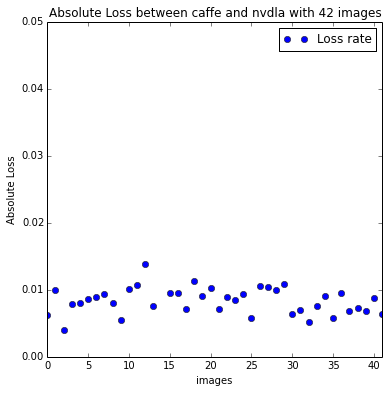

In [15]:
pixel_width = 6
pixel_height = 6
plt.figure(figsize=(pixel_width, pixel_height))
aa = range(0,42)
l1, = plt.plot(aa,caffe_nvdla_loss,'ro', label = 'Loss rate', color = 'blue')

plt.xlim((0, 41))
plt.ylim((0, 0.05))
plt.title("Absolute Loss between caffe and nvdla with 42 images")
plt.xlabel('images')
plt.ylabel('Absolute Loss')

plt.legend() #, labels = ['caffe', 'no mean'], loc = 'best')

plt.show()